Qiskit is an open-source SDK for working with quantum computers at the level of circuits, algorithms, and application modules. It is a popular quantum programming framework mainly for consisting of advanced modules for applications in chemistry, optmization, finance and machine learning.

At IPE, we developed a Qiskit provider that allows access to the QiController quantum system.

This is a tutorial on how to run Qiskit circuits on the available QiController backends.

### Installing

Qiskit best supports Python 3.7 or later versions.
To install the Qiskit package, which includes Terra, Aer, Ignis, and Aqua, and make it available globally using "import qiskit", type:

`$ pip install qiskit`

### Getting started

To ensure the demonstrations have the required Python modules and libraries, import the necessary modules for creating Qiskit circuits and running them on the QiController backend.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt

import qiclib as ql
from qiclib.code import *

from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

/home/sbenrached/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


### Create a quantum circuit using Qiskit

We here present a simple circuit to create a Bell State using Qiskit:

$$|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$ 

Each qubit in Qiskit is initialized to the $|0\rangle$ state.
To create the Bell state $|\Phi^+\rangle $, we apply a Hadamard gate to the first qubit and then apply a CNOT gate such that the first qubit is the control and the second is the target. We then measure the two qubits and the results will be stored in two classical bits.

In [2]:
# Create a quantum circuit of 2 qubits and 2 classical bits
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# Apply Hadamard gate on the first qubit
qc.h(0)

# Apply CNOT gate such that the first qubit is the control and the second is the target
qc.cx(0,1)

# Apply barrier to all qubits
qc.barrier()

# # Measure the 2 qubits and store results in corresponding classical bits
qc.measure(0,0)
qc.measure(1,1)

We can visualize our circuit using visualization tools from matplotlib module.

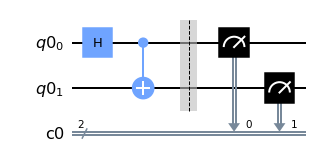

In [3]:
qc.draw(output = 'mpl')

### Define the QiController

To execute the Qiskit circuit on the QiController backend, we first call the backend to use.
The QiController needs to be powered and connected to the same network as the control computer. It can then be accessed via its IP address or host name. <br>
In this tutorial, we will execute the above Qiskit circuit on the Slot3 platform available at the lab.

In [4]:
qic = ql.QiController('slot3-platform')

Platform driver version: v0.1.0 +595 (b2bf076d, 29.11.2021 15:02) <dirty>
Establishing gRPC connection to slot3-platform:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-12-02 17:01:46 (rev. 714)
Firmware with 3 digital unit cells detected.


### Define the coupling map for the 2-qubit gates used in circuit

In order to couple 2 qubits and apply 2-qubit gates, such as CNOT and iSWAP gates, it is important to specify which 2 qubits are subject to the operation. This is what we refer to as "coupling map", and the qubit pairs should be passed in a list to the QiController provider.

In [5]:
# Add coupling map of qubits q0 and q1 (or q1 and q0) subject to the CNOT operation 
coupling_map = [[0,1]]

### Define sample

Before running experiments on the QiController backend, we need to configure it by setting physical properties for the experiment.<br>

The sample consists of the same number of cells as the number of qubits given in the Qiskit circuit to execute, where each cell corresponds to a qubit and defines all its relevant properties. This can be pulse lengths, frequencies, but also other experiment-related parameters. An additional cell is used for coupling each pair of qubits subject to the 2-qubit gates in the circuit, and these cells also define the physical properties of the coupling signal such as its frequency and length.<br>

Note that, generally, not all qubits in a quantum chip have the same physical properties, so each cell should be calibrated seperately.

In [6]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiCells(3) 

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9 # s readout pulse length
sample[0]["rec_length"] = 100e-9 # s recording window size
sample[0]["rec_frequency"] = 60e6 # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9 # s electrical delay
sample[0]["pi"] = 160e-9 # s Pi pulse duration
sample[0]["T1"] = 2e-6 # s decoherence time
sample[0]["T2"] = 3e-6 # s dephasing time

# Second cell corresponds to the second qubit of the circuit
sample[1]["rec_pulse"] = 116e-9 # s readout pulse length
sample[1]["rec_length"] = 100e-9 # s recording window size
sample[1]["rec_frequency"] = 90e6 # Hz readout pulse frequency
sample[1]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[1]["rec_offset"] = 20e-9 # s electrical delay
sample[1]["pi"] = 160e-9 # s Pi pulse duration
sample[1]["T1"] = 2e-6 # s decoherence time
sample[1]["T2"] = 3e-6 # s dephasing 

# One additional cell to couple the two qubits q0 and q1, and apply the CNOT gate
sample[2]["gauss_on_pulse_length"] = 24e-9 # s 
sample[2]["rectangular_pulse_length"] = 132e-9 # s 
sample[2]["gauss_off_pulse_length"] = 24e-9 # s 
sample[2]["pulse_frequency"] = 854e6 # Hz

### Amplitude calibration

We calibrate the electrical delay of the readout pulse through the experimental setup. <br>
`qiclib` offers an automated scheme for this purpose, optimizing for the highest signal amplitude at the IF frequency. Manual calibration (see other methods inside `ql.init`) is also possible.
This will perform multiple experiments on the QiController to determine the electrical delay and to record the final readout window. It will also plot the resulting data using matplotlib.
The optimal delay will be stored as `rec_offset` inside the sample object so it can be used for the following experiments.

In [7]:
qic.cell[0].manipulation.amplitude_calibration = (0.5,0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5,0.5)

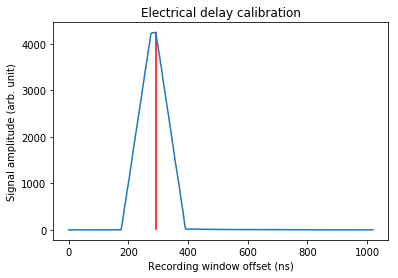

Optimal offset: 292.0 ns
Mirror sideband is 14.5 dB suppressed at recording input


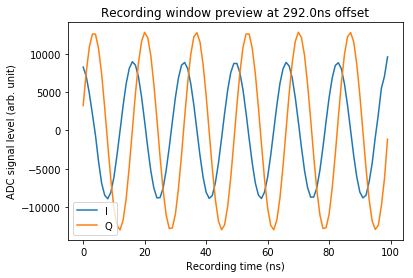

In [8]:
ql.init.calibrate_readout(qic, sample, averages=1000)

### State calibration

We have put the QiController into operation, the next step is to calibrate the states $|0\rangle$ and $|1\rangle$.<br>
To do this, we perform single shot readouts to plot the clouds of the two states $|0\rangle$ and $|1\rangle$, and then distinguish between them with a seperation line. The cloud of single readout results above the line represents the $|0\rangle$ states, and the shots below represent the $|1\rangle$ states.<br>
Each cell from the sample that corresponds to a qubit in the Qiskit circuit needs to be calibrated seperately.

In [9]:
with QiJob() as job_test:
    
    q = QiCells(1)
    
    ql.jobs.Readout(q[0], "result")
    
job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

In [10]:
result = job_test.cells[0].data("result")

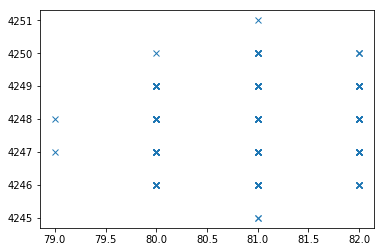

In [11]:
import matplotlib.pyplot as plt

plt.plot(result[0][0], result[0][1], "x")

In [12]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(79, 4249, 82, 4249)
qic.cell[1].recording.state_config = calculate_stater_config(79, 4249, 82, 4249)

### Execute circuit on QiController backend

Now that we have what's necessary to execute the circuit on the QiController backend, we call the QiController provider with the sample used, create a backend according to the provider parameters, then run our cicuit on the defined backend for a certain number of shots, and display the measuremet results in terms of counts. We can use the histogram visualization tool from Qiskit to display the probability distribition of quantum states. <br><br>
If you are using gates that are not supported by the QiController backend (you can check the gates supported by running `backend.configuration().supported_gates`), you can transpile the circuit to the basis gates of the QiController backend.
Read more about the Qiskit transpiler [here](./product/download.html).

In [13]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample, coupling_map)

In [14]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

In [15]:
# Create a job by running the circuit on the backend for a number of shots and return the states
job = backend.run(qc, 10, memory=True)

In [16]:
# Retrieve the measurement results in terms of list of states
states = job.get_memory()
print(states)

['01', '01', '01', '01', '01', '01', '01', '01', '01', '01']


In [17]:
# Create a job by running the circuit on the backend for a number of shots and return the counts
job = backend.run(qc, 10, memory=False)

# Retrieve the measurement results in terms of list of counts
counts = job.get_counts()
print(counts)

{'000': 0, '001': 10, '010': 0, '011': 0}


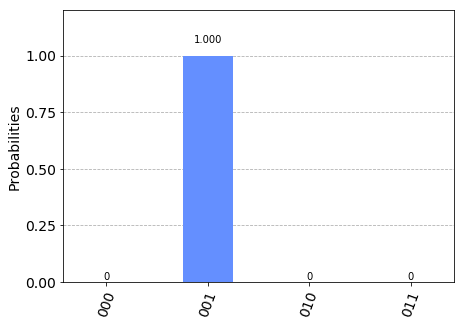

In [18]:
from qiskit.visualization import plot_histogram

# Display the probability distribution of the quantum states
plot_histogram(counts)

We can access the backend configuration to learn more of the design of the backend:

In [19]:
# Access the backend configuration parameters. e.g: the backend name
print(backend.configuration().backend_name)

slot3-platform


In [20]:
provider.backends

[<QiController_backend('slot3-platform')>]